<a href="https://colab.research.google.com/github/adamclark3224423/Adult-Dataset/blob/main/Copy_of_Adult_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import sklearn

In [ ]:
from math import log2,sqrt 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing 
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [ ]:
from six import StringIO
from IPython.display import Image
import pydotplus
from tqdm.notebook import tqdm_notebook as tqdm

In [ ]:
column_names =['age', 'workclass','fnlwg', "education", 'education_num', 'marital_status',
                 "occupation", "relationship", "race", "sex", 'capital_gain', 'capital_loss', "hours_per_week",
               'country', 'target']
data = pd.read_csv("adult_data.csv",header=None, names = column_names)
data.head()

,age,workclass,fnlwg,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
data.describe()

,age,fnlwg,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwg           32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  country         32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
print(f'dataset shape is{data.shape}')

dataset shape is(32561, 15)


In [ ]:
def entropy(class_y):

    if len(class_y) <=1:
        return 0

    total_count = np.bincount(class_y)
    probabilities = total_count[np.nonzero(total_count)] / len(class_y)
    if len(probabilities) <= 1:
        return 0

    return -np.sum(probabilities * np.log(probabilities))/ np.log(len(probabilities))


In [ ]:
X=[0,0,0,1,1,1]
z=np.bincount(X)
print(z)
z[np.nonzero(z)]/len(X)

[3 3]


array([0.5, 0.5])

In [ ]:
def information_gain(previous_y, current_y):
  
    conditional_entropy=0
    for y in current_y:
        conditional_entropy += (entropy(y)*len(y)/len(previous_y))
    info_gain = entropy(previous_y) - conditional_entropy
    return info_gain


In [ ]:
#Test Case
test_class_y = [0,0,0,1,1,1,1,1]
print(entropy(test_class_y))

previous_y=[0,0,0,1,1,1]
current_y=[0,0],[1,1,1,0]
print(information_gain(previous_y,current_y))


0.954434002924965
0.4591479170272448


In [ ]:
def partition_classes(X, y, split_attribute, split_val):
    
    X = np.array(X)
    column_split = X[:,split_attribute]
    X_left = []
    y_right = []
    X_right =[]
    y_left = []

    counter=0

    if isinstance(split_val,str) == False:
        for i in column_split:
            if i <= split_val:
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter+=1
         
    else:
        for i in column_split:
            if i == split_val:
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter+=1;

    return X_left, X_right, y_left, y_right


In [ ]:
def find_best_split(X, y, split_attribute):


    best_info_gain = 0
    X = np.array(X)
    column_split = X[:,split_attribute]

    column_split = np.unique(column_split)
    best_split_val = column_split[0]

    for split_val in column_split:
        current_X_left, current_X_right, current_y_left, current_y_right = partition_classes(X, y, split_attribute, split_val)
        current_y = []
        current_y.append(current_y_left)
        current_y.append(current_y_right)

        current_info_gain = information_gain(y,current_y)
        if current_info_gain > best_info_gain:
            best_info_gain = current_info_gain 
            best_split_val = split_val

    return best_split_val, best_info_gain


In [ ]:
def find_best_feature(X, y):

    best_info_gain = 0
    best_feature = 0
    best_split_val = 0
    for feature_index in range(len(X[0])):
        current_best_split_val, current_best_info_gain = find_best_split(X, y, feature_index) 
        if current_best_info_gain>best_info_gain:
            best_info_gain = current_best_info_gain
            best_feature = feature_index
            best_split_val = current_best_split_val
    return best_feature, best_split_val


In [ ]:
class MyDecisionTree(object):
    def __init__(self, max_depth=None):

        self.tree = {}
        self.residual_tree = {}
        self.max_depth = max_depth

    def fit(self, X, y, depth):

        unique_labels=np.unique(y)
        if (len(unique_labels)==1) or (depth == max_depth):
            unique_labels, counts_unique_labels = np.unique(y, return_counts=True)
            index = counts_unique_labels.argmax()
            classification = unique_labels[index]
            return classification
         

        best_feat, best_split = find_best_feature(X, y)
        best_split, information_gain = find_best_split(X, y, best_feat)
        X_left, X_right, y_left, y_right = partition_classes(X, y, best_feat, best_split)

        if isinstance(best_split,str):
            question = "{} == {}".format(best_feat, best_split)
        else:
            question = "{} <= {}".format(best_feat, best_split)
        node = {question: []}

        depth+=1
        yes_answer = self.fit(X_left,y_left, depth)
        no_answer = self.fit(X_right, y_right, depth)

        if yes_answer == no_answer:
            node = yes_answer
        else:
            node[question].append(yes_answer)
            node[question].append(no_answer)
        self.tree = node
        return node
                                                    
    def predict(self, record,flag=1):
        if flag == 1:
            self.residual_tree = self.tree
        question = list(self.residual_tree.keys())[0]
        feature, comparison, value = question.split()

        if comparison == "==":
            if record[int(feature)] == value:
                answer = self.residual_tree[question][0]
            else:
                answer = self.residual_tree[question][1]
        elif comparison == "<=":
            if record[int(feature)] <= float(value):
                answer = self.residual_tree[question][0]
            else:
                answer = self.residual_tree[question][1]
            
            
        if not isinstance(answer, dict):
            return answer       
        else:
            self.residual_tree = answer
            return self.predict(record,0) 

In [ ]:
def DecisionTreeEvaluation(id3,X,y, verbose=False):

    y_predicted = []
    for record in X:
        y_predicted.append(id3.predict(record))
   
    results = [prediction == truth for prediction, truth in zip(y_predicted, y)]
    
    accuracy = float(results.count(True)) / float(len(results))
    if verbose:
        print("accuracy: %.4f" % accuracy)
    return accuracy 

In [ ]:
column_names =['age', 'workclass','fnlwg', "education", 'education_num', 'marital_status',
                 "occupation", "relationship", "race", "sex", 'capital_gain', 'capital_loss', "hours_per_week",
               'country', 'target']
df_train = pd.read_csv("adult_data.csv",header=None, names = column_names)
df_train.drop(columns = "fnlwg", inplace = True)
df_train.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
column_names =['age', 'workclass','fnlwg', "education", 'education_num', 'marital_status',
                 "occupation", "relationship", "race", "sex", 'capital_gain', 'capital_loss', "hours_per_week",
               'country', 'target']
df_test = pd.read_csv("adult_test.csv",header=None, names = column_names)
df_test.drop(columns = "fnlwg", inplace = True)
df_test.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [ ]:
df_test = df_test.iloc[1:]
df_test.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
1,25,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [ ]:
df_test['age'] = pd.to_numeric(df_test['age'])

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 1 to 16281
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16281 non-null  int64  
 1   workclass       16281 non-null  object 
 2   education       16281 non-null  object 
 3   education_num   16281 non-null  float64
 4   marital_status  16281 non-null  object 
 5   occupation      16281 non-null  object 
 6   relationship    16281 non-null  object 
 7   race            16281 non-null  object 
 8   sex             16281 non-null  object 
 9   capital_gain    16281 non-null  float64
 10  capital_loss    16281 non-null  float64
 11  hours_per_week  16281 non-null  float64
 12  country         16281 non-null  object 
 13  target          16281 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 1.7+ MB


In [ ]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
print(y_train.head())
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
print(y_train)

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: target, dtype: object
[0 0 0 ... 0 0 1]


In [ ]:
X_test = df_test.iloc[:,: -1]
y_test = df_test.iloc[:,-1]

label_enc = LabelEncoder()
y_test = label_enc.fit_transform(y_test)
y_test

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
X_train_np, X_test_np = X_train.to_numpy(), X_test.to_numpy()
max_depth = 3
initial_depth = 0
id3_dt = MyDecisionTree(max_depth)
print("fitting the decision tree")
id3_dt.fit(X_train_np, y_train, initial_depth)
DecisionTreeEvaluation(id3_dt,X_train_np,y_test, True)

fitting the decision tree
accuracy: 0.7404


0.7403722130090289

In [ ]:
id3_dt.tree

{'4 ==  Married-civ-spouse': [{'3 <= 12': [{'9 <= 5013': [0, 1]}, 1]},
  {'9 <= 6849': [0, {'0 <= 20': [0, 1]}]}]}

In [ ]:
X_train.head(3)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [ ]:
X_train_encoded = X_train.copy()
for key in ['workclass', "education", 'marital_status',
            "occupation", "relationship", "race", "sex", 'country']:
    label_enc_x = LabelEncoder()
    X_train_encoded[key] = label_enc_x.fit_transform(X_train[key])

In [ ]:
X_test_encoded = X_test.copy()
for key in ['workclass', "education", 'marital_status',
            "occupation", "relationship", "race", "sex", 'country']:
    label_enc_x = LabelEncoder()
    X_test_encoded[key] = label_enc_x.fit_transform(X_test[key])

In [ ]:
clf = tree.DecisionTreeClassifier( criterion='entropy', max_depth = max_depth)
clf.fit(X_train_encoded, y_train)
y_pred = clf.predict(X_test_encoded)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.839199066396413


In [ ]:
X_train

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [ ]:
clf = tree.DecisionTreeClassifier( criterion='entropy', max_depth = max_depth)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

ValueError: ignored

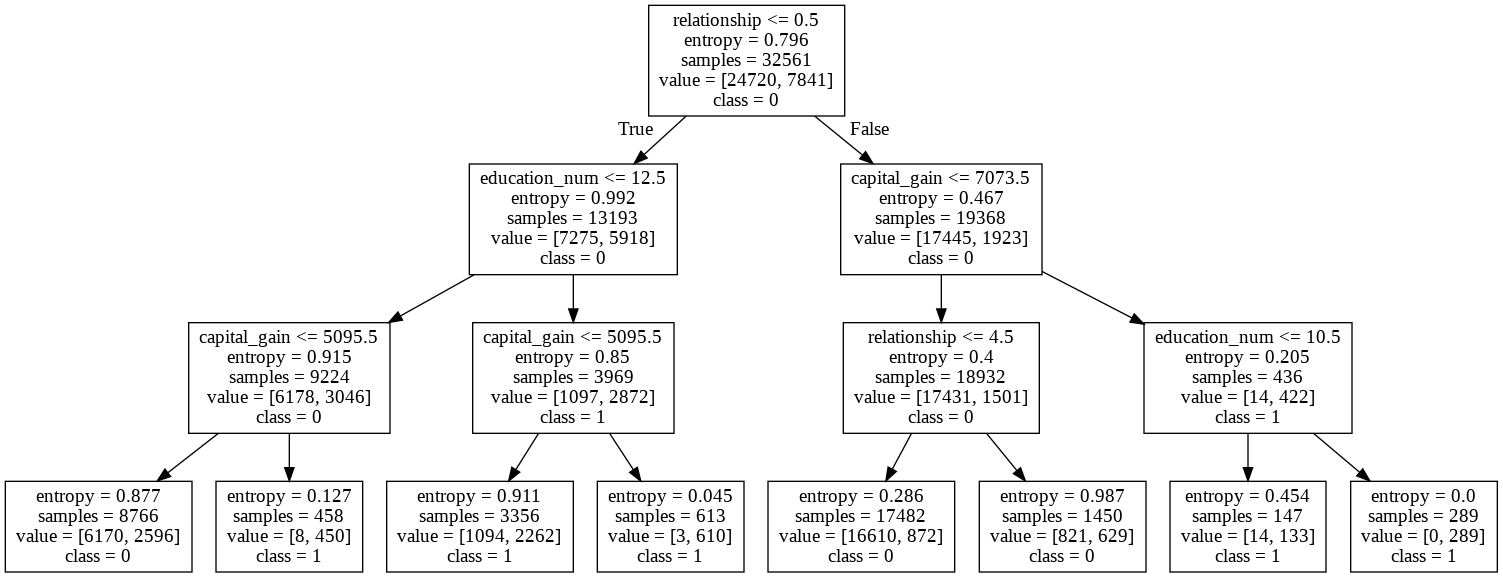

In [ ]:
feature_names = list(X_train)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = feature_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Iris_tree.png')
Image(graph.create_png())